In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import  KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy.stats import mode
import warnings
warnings.simplefilter(action='ignore', category=Warning)


In [19]:
raw_train_data = pd.read_csv('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\train.csv')
raw_test_data = pd.read_csv('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\test.csv')
raw_valid_data = pd.read_csv('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\raw-data\\valid.csv')
embedding_train_data = np.load('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\embeddings-data\\train-embeddings.npy')
embedding_test_data = np.load('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\embeddings-data\\test-embeddings.npy')
embedding_valid_data = np.load('C:\\Users\\xu741\\Desktop\\IML\\a1\\a3\\embeddings-data\\valid-embeddings.npy')

In [20]:
# # repalce nan with mean value 
# raw_train_data.fillna(raw_train_data.mean(),inplace=True)

# # convert requirements and role column into bag-of-words representation 
# raw_train_data['requirements_and_role'].fillna('', inplace=True)

# sepearte labeled data and unlableled
labeled_embedding_train_data, unlabeled_embedding_train_data = embedding_train_data[:8000], embedding_train_data[-5902:]


bins = [-float('inf'), 0, 1, 2, 3, 4, 5, 6, 7, 8, float('inf')]
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

raw_train_data['salary_bin_cat'] = pd.cut(raw_train_data['salary_bin'], bins=bins, labels=labels)
raw_valid_data['salary_bin_cat'] = pd.cut(raw_valid_data['salary_bin'], bins=bins, labels=labels)

# get categorical data 
salary_bin_raw_train = raw_train_data['salary_bin_cat']
salary_bin_raw_valid = raw_valid_data['salary_bin_cat']

# get Target labels and untarget labels for train data 
labeled_train_data_y = salary_bin_raw_train[:8000]
unlabeled_train_data_y = salary_bin_raw_train[-5902:]

X_valid_raw = raw_valid_data['requirements_and_role']
y_valid = salary_bin_raw_valid


Active learning is an iterative process that involves the following steps:

1. Initialize: Start with a small labeled dataset.

2. Train: Train a machine learning model on the labeled dataset.

3. Select: Select a subset of unlabeled data points for which the model is uncertain or has low confidence in its predictions.

4. Query: Query an oracle (human annotator or domain expert) to obtain labels for the selected data points.

5. Update: Add the newly labeled data points to the labeled dataset and retrain the model.

6. Repeat: Repeat steps 3-5 until a satisfactory level of performance is achieved or until labeling new data points no longer provides a significant improvement in performance.

The goal of active learning is to train a model that performs well with as few labeled data points as possible, by strategically selecting which unlabeled data points to query for labels.

In [21]:
knn = KNeighborsClassifier()
gnb = GaussianNB()
rf = RandomForestClassifier()
svc = SVC()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_embedding, y_train_embedding = labeled_embedding_train_data, labeled_train_data_y

models = { 'gnb': gnb, 'knn': knn, 'rf': rf, 'svc': svc}
accuracies = {'gnb': [], 'knn': [], 'rf': [], 'svc': []}

for i, (train_index, test_index) in enumerate(kf.split(X_train_embedding)):

    X_train, X_test = X_train_embedding[train_index], X_train_embedding[test_index]
    y_train, y_test = y_train_embedding[train_index], y_train_embedding[test_index]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[model_name].append(accuracy)
        

avg_accuracy_embedding_gnb = np.mean(accuracies['gnb'])
avg_accuracy_embedding_knn = np.mean(accuracies['knn'])
avg_accuracy_embedding_rf = np.mean(accuracies['rf'])
avg_accuracy_embedding_svc = np.mean(accuracies['svc'])

Average accuracies:
Gaussian Naive Bayes:  0.229
K-Nearest Neighbors:  0.200625
Random Forest:  0.23375000000000004
Support Vector Machine:  0.252


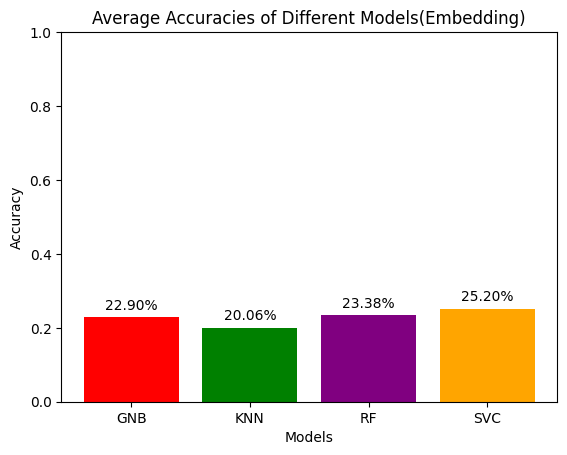

In [22]:
# Print average accuracies
print("Average accuracies:")
print("Gaussian Naive Bayes: ", avg_accuracy_embedding_gnb)
print("K-Nearest Neighbors: ", avg_accuracy_embedding_knn)
print("Random Forest: ", avg_accuracy_embedding_rf)
print("Support Vector Machine: ", avg_accuracy_embedding_svc)

# Create a bar plot
models = [ 'GNB', 'KNN', 'RF', 'SVC']
accuracies = [avg_accuracy_embedding_gnb, avg_accuracy_embedding_knn, 
              avg_accuracy_embedding_rf, avg_accuracy_embedding_svc]
plt.bar(models, accuracies, color=['red', 'green', 'purple', 'orange'])
plt.title('Average Accuracies of Different Models(Embedding)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0,1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.02, f"{acc*100:.2f}%", ha='center')
plt.show()

In [40]:
models = { 'gnb': gnb, 'knn': knn, 'rf': rf, 'svc': svc}
unlabeled_preds = {model: [] for model in models}

# Split data into labeled and unlabeled sets
X_labeled, X_unlabeled, y_labeled, y_unlabeled = labeled_embedding_train_data, unlabeled_embedding_train_data, labeled_train_data_y, unlabeled_train_data_y

# Choose a pool of unlabeled data to query from
X_pool, y_pool= unlabeled_embedding_train_data, unlabeled_embedding_train_data

batch_size = 100

# Active learning loop
num_queries = int(len(X_unlabeled) / batch_size)
for i in range(num_queries-5):
    print(f"Query {i+1}/{num_queries-5}")
    
    # Compute committee disagreement for each batch of unlabeled data points
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    batch_X_pool, batch_y_pool = X_pool[start_idx:end_idx], y_pool[start_idx:end_idx]
    disagreements = []
    print(y_pool.shape)

    for x in batch_X_pool:
        preds = []
        for modelName, model in models.items():
            preds.append(model.predict(x.reshape(1, -1))[0])
        disagreements.append(1 - mode(preds)[1] / len(models))
        
    # Select the top k unlabeled data points with the highest disagreement
    k = min(batch_size, len(X_pool))
    query_idxs = np.argsort(disagreements)[-k:]
    query_X, query_y = X_pool[query_idxs], y_pool[query_idxs]
    
    query_X = query_X.reshape(batch_size*query_X.shape[1],query_X.shape[-1])
    

    query_preds = []
    for modelName, model in models.items():
        query_preds.append(model.predict(query_X))
    query_y = mode(np.vstack(query_preds))[0]
    
    print(query_y.shape)

    # Add queried point to labeled data
    print("labeled data size before {} labeled training data y length before {}".format(X_labeled.shape[0], y_labeled.shape[0]))
    X_labeled = np.vstack((X_labeled, query_X))
    y_labeled = y_labeled.append(pd.Series(np.squeeze(query_y)), ignore_index=True)
    print("labeled data size after {} labeled training data y length before {}".format(X_labeled.shape[0], y_labeled.shape[0]))
    
    # Remove queried point from unlabeled data pool
    X_pool, y_pool = np.delete(X_pool, query_idxs, axis=0), np.delete(y_pool, query_idxs)
    
    # Re-train each model on the updated labeled data
    for modelName, model in models.items():
        model.fit(X_labeled, y_labeled)
    
    # Compute unlabeled predictions for each model on the updated unlabeled data pool
    for modelName, model in models.items():
        preds = model.predict(X_pool)
        unlabeled_preds[modelName].append(preds)


Query 1/10
[array([0.25])]
[array([0.25]), array([0.5])]
[array([0.25]), array([0.5]), array([0.25])]
[array([0.25]), array([0.5]), array([0.25]), array([0.])]
[array([0.25]), array([0.5]), array([0.25]), array([0.]), array([0.])]
[array([0.25]), array([0.5]), array([0.25]), array([0.]), array([0.]), array([0.])]
[array([0.25]), array([0.5]), array([0.25]), array([0.]), array([0.]), array([0.]), array([0.25])]
[array([0.25]), array([0.5]), array([0.25]), array([0.]), array([0.]), array([0.]), array([0.25]), array([0.25])]
[array([0.25]), array([0.5]), array([0.25]), array([0.]), array([0.]), array([0.]), array([0.25]), array([0.25]), array([0.25])]
[array([0.25]), array([0.5]), array([0.25]), array([0.]), array([0.]), array([0.]), array([0.25]), array([0.25]), array([0.25]), array([0.5])]
[array([0.25]), array([0.5]), array([0.25]), array([0.]), array([0.]), array([0.]), array([0.25]), array([0.25]), array([0.25]), array([0.5]), array([0.5])]
[array([0.25]), array([0.5]), array([0.25])

KeyboardInterrupt: 

Get Accuracies for the new data

In [ ]:
accuracies = {'gnb': [], 'knn': [], 'rf': [], 'svc': []}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
print("labeled data size after {} labeled training data y length before {}".format(X_labeled.shape[0], y_labeled.shape[0]))
for i, (train_index, test_index) in enumerate(kf.split(X_labeled)):

    X_train, X_test = X_labeled[train_index], X_labeled[test_index]
    y_train, y_test = y_labeled[train_index], y_labeled[test_index]

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[model_name].append(accuracy)
        

avg_accuracy_embedding_gnb = np.mean(accuracies['gnb'])
avg_accuracy_embedding_knn = np.mean(accuracies['knn'])
avg_accuracy_embedding_rf = np.mean(accuracies['rf'])
avg_accuracy_embedding_svc = np.mean(accuracies['svc'])

In [ ]:
# Print average accuracies
print("Average accuracies:")
print("Gaussian Naive Bayes: ", avg_accuracy_embedding_gnb)
print("K-Nearest Neighbors: ", avg_accuracy_embedding_knn)
print("Random Forest: ", avg_accuracy_embedding_rf)
print("Support Vector Machine: ", avg_accuracy_embedding_svc)

# Create a bar plot
models_str = [ 'GNB', 'KNN', 'RF', 'SVC']
accuracies = [avg_accuracy_embedding_gnb, avg_accuracy_embedding_knn, 
              avg_accuracy_embedding_rf, avg_accuracy_embedding_svc]
plt.bar(models_str, accuracies, color=['red', 'green', 'purple', 'orange'])
plt.title('Average Accuracies of Different Models(Embedding)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0,1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.02, f"{acc*100:.2f}%", ha='center')
plt.show()

Optimize using random search

In [ ]:
models_optimize = {
    'gnb': {
        'estimator': gnb,
        'param_grid': {
            'var_smoothing': np.logspace(-15, -5, 200)
        }
    },
    'knn': {
        'estimator': knn,
        'param_grid': {
            'n_neighbors': range(1,20),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    },
    'rf': {
        'estimator': rf,
        'param_grid': {
            'n_estimators': [50, 100, 200, 500, 1000],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_leaf': [1, 2, 4, 8]
        }
    },
    'svc': {
        'estimator': svc,
        'param_grid': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'kernel': ['linear','poly', 'rbf', 'sigmoid'],
            'degree': [0, 1, 2, 3, 4, 5, 6],
            'probability': [True]
        }
    }
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

for model_name, model_data in models_optimize.items():
    rs = RandomizedSearchCV(
        model_data['estimator'], 
        param_distributions=model_data['param_grid'], 
        cv=kf, 
        n_iter=20, 
        n_jobs=-1, 
        random_state=42
    )
    rs.fit(embedding_valid_data, y_valid)
    print(f"Best parameters for {model_name}: {rs.best_params_}")
    print(f"Best CV score for {model_name}: {rs.best_score_:.3f}")
    
    # Update the model with the best parameters
    model_data['estimator'] = rs.best_estimator_

Retrain the model using k fold

In [ ]:
accuracies = {'gnb': [], 'knn': [], 'rf': [], 'svc': []}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
print("labeled data size after {} labeled training data y length before {}".format(X_labeled.shape[0], y_labeled.shape[0]))
for i, (train_index, test_index) in enumerate(kf.split(X_labeled)):

    X_train, X_test = X_labeled[train_index], X_labeled[test_index]
    y_train, y_test = y_labeled[train_index], y_labeled[test_index]

    for model_name, model_data in models_optimize.items():
        model = model_data['estimator']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[model_name].append(accuracy)
        

avg_accuracy_embedding_gnb = np.mean(accuracies['gnb'])
avg_accuracy_embedding_knn = np.mean(accuracies['knn'])
avg_accuracy_embedding_rf = np.mean(accuracies['rf'])
avg_accuracy_embedding_svc = np.mean(accuracies['svc'])

In [ ]:
accuracies = {}
for model_name, model_data in models_optimize.items():
    model = model_data['estimator']
    y_pred = model.predict(embedding_valid_data)
    accuracy = accuracy_score(y_valid, y_pred)
    accuracies[model_name] = accuracy
print(accuracies)
plt.bar(range(len(accuracies)), list(accuracies.values()), align='center')
plt.xticks(range(len(accuracies)), list(accuracies.keys()))
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracies')
plt.show()

Stack all models to trian 

In [ ]:
from sklearn.ensemble import StackingClassifier
estimators = [(model_name, model_data['estimator']) for model_name, model_data in models_optimize.items()]

# Define meta-estimator
stacked_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
# Fit and predict
# Initialize lists for storing accuracy scores
stacked_clf_scores = []

# Iterate over the k folds
X_train, y_train = X_labeled,y_labeled
for train_index, test_index in kf.split(X_train):
    
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # Fit the stacked classifier on the training set
    stacked_clf.fit(X_train_fold, y_train_fold)
    
    # Evaluate the stacked classifier on the validation set
    y_pred = stacked_clf.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred)
    stacked_clf_scores.append(accuracy)

# Calculate and print the mean accuracy across all folds
print('Stacked Classifier Mean Accuracy:', np.mean(stacked_clf_scores))